# DCGAN_for_CIFAR10

In [2]:
import numpy as np

from keras.datasets.cifar10 import load_data
from keras.optimizers import adam_v2
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D
from keras.layers import Conv2DTranspose, LeakyReLU, Dropout
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt

In [3]:
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

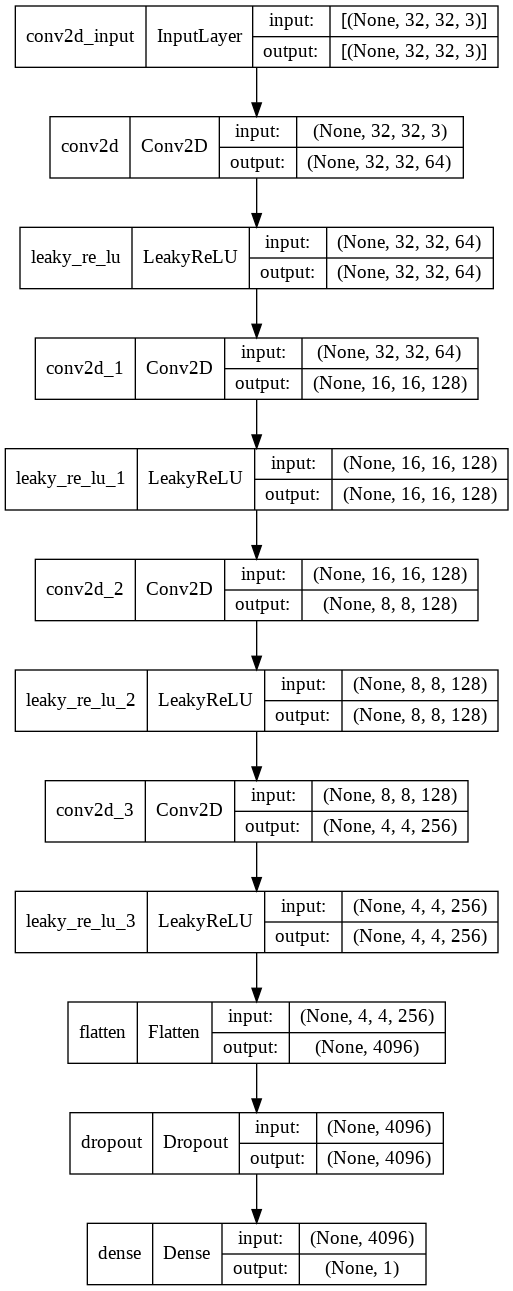

In [4]:
discriminator_model = define_discriminator()
discriminator_model.summary()
plot_model(discriminator_model, to_file = 'discriminator_model.png', show_shapes = True, show_layer_names = True)

In [5]:
def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

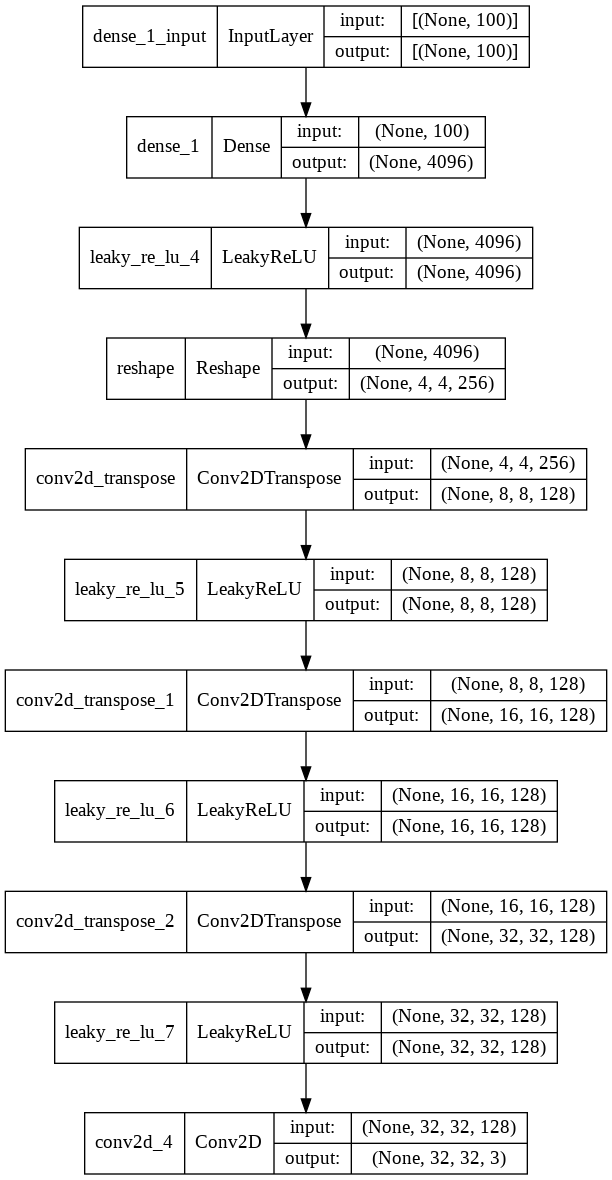

In [6]:
latent_dim = 100
generator_model = define_generator(latent_dim)
generator_model.summary()
plot_model(generator_model, to_file = 'generator_model.png', show_shapes = True, show_layer_names = True)

In [7]:
def define_gan(generator, discriminator):
	discriminator.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential (Sequential)     (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


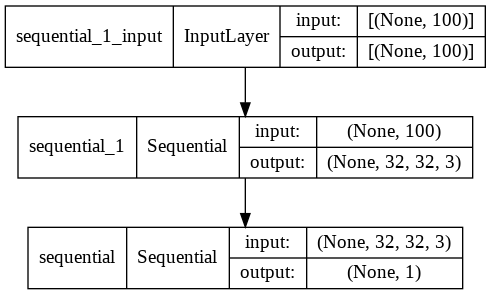

In [8]:
gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file = 'gan_model.png', show_layer_names = True, show_shapes = True)

In [9]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5
	return X

In [10]:
def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y

In [11]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = np.zeros((n_samples, 1))
	return X, y

In [12]:
def save_plot(examples, epoch, n=7):
	examples = (examples + 1) / 2.0
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i])
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.show()
 
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=150):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  print('=> Epoch ' + str(epoch + 1) + ' Real Acc.: ' + str(acc_real*100) + ' Fake Acc.: '+ str(acc_fake*100))
  save_plot(x_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  generator.save(filename)

In [13]:
def train_gan(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d' % (n_epochs, n_batch, half_batch, bat_per_epo))
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = discriminator.train_on_batch(X_real, y_real)
      X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      d_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      if (j+1)/bat_per_epo in (1/bat_per_epo, 1/2, 1):
        print('> Epoch %d, batch %d/%d: d_loss1=%.3f, d_loss2=%.3f, g_loss=%.3f' % 
              (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    if (i+1) % 10 == 0:
      summarize_performance(i, generator, discriminator, dataset, latent_dim)

In [14]:
latent_dim = 100

In [15]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

In [16]:
dataset = load_real_samples()

170508288/170498071 [==============================] - 2s 0us/step


n_epochs=200, n_batch=128, 1/2=64, b/e=390
> Epoch 1, batch 1/390: d_loss1=0.694, d_loss2=0.696, g_loss=0.691
> Epoch 1, batch 195/390: d_loss1=0.727, d_loss2=0.272, g_loss=1.743
> Epoch 1, batch 390/390: d_loss1=0.654, d_loss2=0.737, g_loss=1.184
> Epoch 2, batch 1/390: d_loss1=0.790, d_loss2=0.850, g_loss=1.141
> Epoch 2, batch 195/390: d_loss1=0.601, d_loss2=0.562, g_loss=1.080
> Epoch 2, batch 390/390: d_loss1=0.526, d_loss2=0.479, g_loss=1.339
> Epoch 3, batch 1/390: d_loss1=0.467, d_loss2=0.447, g_loss=1.285
> Epoch 3, batch 195/390: d_loss1=0.673, d_loss2=0.630, g_loss=1.224
> Epoch 3, batch 390/390: d_loss1=0.616, d_loss2=0.608, g_loss=1.043
> Epoch 4, batch 1/390: d_loss1=0.631, d_loss2=0.612, g_loss=1.031
> Epoch 4, batch 195/390: d_loss1=0.631, d_loss2=0.603, g_loss=0.976
> Epoch 4, batch 390/390: d_loss1=0.637, d_loss2=0.846, g_loss=0.859
> Epoch 5, batch 1/390: d_loss1=0.583, d_loss2=0.762, g_loss=0.936
> Epoch 5, batch 195/390: d_loss1=0.514, d_loss2=0.706, g_loss=0.947
>

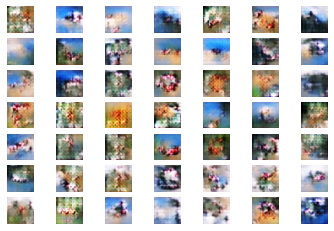

> Epoch 11, batch 1/390: d_loss1=0.581, d_loss2=0.747, g_loss=1.240
> Epoch 11, batch 195/390: d_loss1=0.585, d_loss2=0.646, g_loss=1.076
> Epoch 11, batch 390/390: d_loss1=0.818, d_loss2=0.502, g_loss=1.394
> Epoch 12, batch 1/390: d_loss1=0.600, d_loss2=0.455, g_loss=1.255
> Epoch 12, batch 195/390: d_loss1=0.773, d_loss2=0.650, g_loss=1.223
> Epoch 12, batch 390/390: d_loss1=0.659, d_loss2=0.627, g_loss=0.998
> Epoch 13, batch 1/390: d_loss1=0.591, d_loss2=0.618, g_loss=0.971
> Epoch 13, batch 195/390: d_loss1=0.728, d_loss2=0.657, g_loss=0.915
> Epoch 13, batch 390/390: d_loss1=0.595, d_loss2=0.641, g_loss=0.913
> Epoch 14, batch 1/390: d_loss1=0.716, d_loss2=0.579, g_loss=0.919
> Epoch 14, batch 195/390: d_loss1=0.684, d_loss2=0.628, g_loss=0.871
> Epoch 14, batch 390/390: d_loss1=0.734, d_loss2=0.608, g_loss=0.909
> Epoch 15, batch 1/390: d_loss1=0.718, d_loss2=0.589, g_loss=0.948
> Epoch 15, batch 195/390: d_loss1=0.590, d_loss2=0.631, g_loss=0.913
> Epoch 15, batch 390/390: d_l

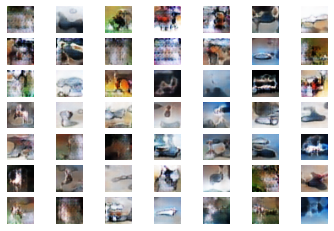

> Epoch 21, batch 1/390: d_loss1=0.640, d_loss2=0.667, g_loss=0.775
> Epoch 21, batch 195/390: d_loss1=0.691, d_loss2=0.645, g_loss=0.857
> Epoch 21, batch 390/390: d_loss1=0.781, d_loss2=0.604, g_loss=0.866
> Epoch 22, batch 1/390: d_loss1=0.762, d_loss2=0.598, g_loss=0.899
> Epoch 22, batch 195/390: d_loss1=0.713, d_loss2=0.663, g_loss=0.797
> Epoch 22, batch 390/390: d_loss1=0.628, d_loss2=0.635, g_loss=0.785
> Epoch 23, batch 1/390: d_loss1=0.636, d_loss2=0.641, g_loss=0.797
> Epoch 23, batch 195/390: d_loss1=0.608, d_loss2=0.707, g_loss=0.895
> Epoch 23, batch 390/390: d_loss1=0.704, d_loss2=0.738, g_loss=0.847
> Epoch 24, batch 1/390: d_loss1=0.661, d_loss2=0.740, g_loss=0.869
> Epoch 24, batch 195/390: d_loss1=0.663, d_loss2=0.583, g_loss=0.848
> Epoch 24, batch 390/390: d_loss1=0.661, d_loss2=0.699, g_loss=0.790
> Epoch 25, batch 1/390: d_loss1=0.658, d_loss2=0.667, g_loss=0.791
> Epoch 25, batch 195/390: d_loss1=0.674, d_loss2=0.655, g_loss=0.841
> Epoch 25, batch 390/390: d_l

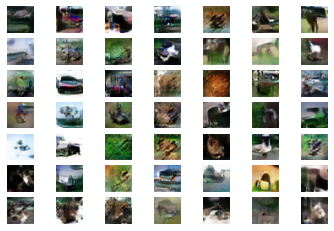

> Epoch 31, batch 1/390: d_loss1=0.661, d_loss2=0.713, g_loss=0.812
> Epoch 31, batch 195/390: d_loss1=0.677, d_loss2=0.697, g_loss=0.793
> Epoch 31, batch 390/390: d_loss1=0.721, d_loss2=0.682, g_loss=0.799
> Epoch 32, batch 1/390: d_loss1=0.681, d_loss2=0.625, g_loss=0.807
> Epoch 32, batch 195/390: d_loss1=0.702, d_loss2=0.685, g_loss=0.829
> Epoch 32, batch 390/390: d_loss1=0.700, d_loss2=0.619, g_loss=0.872
> Epoch 33, batch 1/390: d_loss1=0.703, d_loss2=0.657, g_loss=0.825
> Epoch 33, batch 195/390: d_loss1=0.666, d_loss2=0.638, g_loss=0.819
> Epoch 33, batch 390/390: d_loss1=0.725, d_loss2=0.720, g_loss=0.810
> Epoch 34, batch 1/390: d_loss1=0.661, d_loss2=0.642, g_loss=0.813
> Epoch 34, batch 195/390: d_loss1=0.683, d_loss2=0.675, g_loss=0.814
> Epoch 34, batch 390/390: d_loss1=0.696, d_loss2=0.662, g_loss=0.806
> Epoch 35, batch 1/390: d_loss1=0.630, d_loss2=0.675, g_loss=0.802
> Epoch 35, batch 195/390: d_loss1=0.717, d_loss2=0.635, g_loss=0.826
> Epoch 35, batch 390/390: d_l

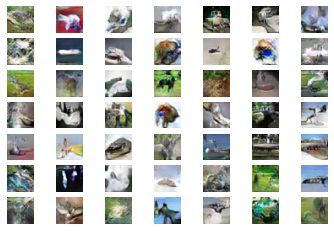

> Epoch 41, batch 1/390: d_loss1=0.650, d_loss2=0.635, g_loss=0.794
> Epoch 41, batch 195/390: d_loss1=0.580, d_loss2=0.704, g_loss=0.847
> Epoch 41, batch 390/390: d_loss1=0.703, d_loss2=0.704, g_loss=0.802
> Epoch 42, batch 1/390: d_loss1=0.610, d_loss2=0.708, g_loss=0.817
> Epoch 42, batch 195/390: d_loss1=0.713, d_loss2=0.672, g_loss=0.830
> Epoch 42, batch 390/390: d_loss1=0.660, d_loss2=0.668, g_loss=0.806
> Epoch 43, batch 1/390: d_loss1=0.633, d_loss2=0.692, g_loss=0.810
> Epoch 43, batch 195/390: d_loss1=0.625, d_loss2=0.670, g_loss=0.789
> Epoch 43, batch 390/390: d_loss1=0.694, d_loss2=0.687, g_loss=0.779
> Epoch 44, batch 1/390: d_loss1=0.665, d_loss2=0.635, g_loss=0.822
> Epoch 44, batch 195/390: d_loss1=0.661, d_loss2=0.641, g_loss=0.792
> Epoch 44, batch 390/390: d_loss1=0.661, d_loss2=0.658, g_loss=0.791
> Epoch 45, batch 1/390: d_loss1=0.664, d_loss2=0.665, g_loss=0.807
> Epoch 45, batch 195/390: d_loss1=0.649, d_loss2=0.719, g_loss=0.782
> Epoch 45, batch 390/390: d_l

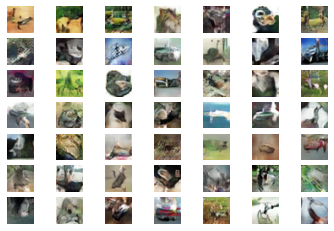

> Epoch 51, batch 1/390: d_loss1=0.647, d_loss2=0.641, g_loss=0.866
> Epoch 51, batch 195/390: d_loss1=0.627, d_loss2=0.665, g_loss=0.849
> Epoch 51, batch 390/390: d_loss1=0.643, d_loss2=0.683, g_loss=0.773
> Epoch 52, batch 1/390: d_loss1=0.645, d_loss2=0.661, g_loss=0.794
> Epoch 52, batch 195/390: d_loss1=0.643, d_loss2=0.598, g_loss=0.821
> Epoch 52, batch 390/390: d_loss1=0.683, d_loss2=0.673, g_loss=0.793
> Epoch 53, batch 1/390: d_loss1=0.634, d_loss2=0.673, g_loss=0.812
> Epoch 53, batch 195/390: d_loss1=0.657, d_loss2=0.704, g_loss=0.826
> Epoch 53, batch 390/390: d_loss1=0.662, d_loss2=0.678, g_loss=0.867
> Epoch 54, batch 1/390: d_loss1=0.684, d_loss2=0.648, g_loss=0.825
> Epoch 54, batch 195/390: d_loss1=0.620, d_loss2=0.625, g_loss=0.822
> Epoch 54, batch 390/390: d_loss1=0.673, d_loss2=0.604, g_loss=0.812
> Epoch 55, batch 1/390: d_loss1=0.662, d_loss2=0.616, g_loss=0.844
> Epoch 55, batch 195/390: d_loss1=0.656, d_loss2=0.726, g_loss=0.840
> Epoch 55, batch 390/390: d_l

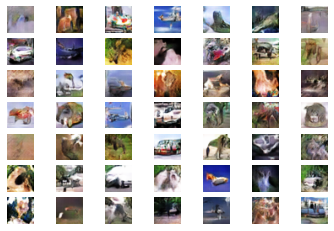

> Epoch 61, batch 1/390: d_loss1=0.633, d_loss2=0.650, g_loss=0.868
> Epoch 61, batch 195/390: d_loss1=0.664, d_loss2=0.668, g_loss=0.856
> Epoch 61, batch 390/390: d_loss1=0.667, d_loss2=0.626, g_loss=0.854
> Epoch 62, batch 1/390: d_loss1=0.656, d_loss2=0.609, g_loss=0.835
> Epoch 62, batch 195/390: d_loss1=0.631, d_loss2=0.664, g_loss=0.852
> Epoch 62, batch 390/390: d_loss1=0.658, d_loss2=0.660, g_loss=0.838
> Epoch 63, batch 1/390: d_loss1=0.631, d_loss2=0.639, g_loss=0.770
> Epoch 63, batch 195/390: d_loss1=0.640, d_loss2=0.624, g_loss=0.849
> Epoch 63, batch 390/390: d_loss1=0.607, d_loss2=0.682, g_loss=0.822
> Epoch 64, batch 1/390: d_loss1=0.599, d_loss2=0.692, g_loss=0.861
> Epoch 64, batch 195/390: d_loss1=0.714, d_loss2=0.644, g_loss=0.876
> Epoch 64, batch 390/390: d_loss1=0.715, d_loss2=0.651, g_loss=0.899
> Epoch 65, batch 1/390: d_loss1=0.641, d_loss2=0.638, g_loss=0.870
> Epoch 65, batch 195/390: d_loss1=0.644, d_loss2=0.624, g_loss=0.845
> Epoch 65, batch 390/390: d_l

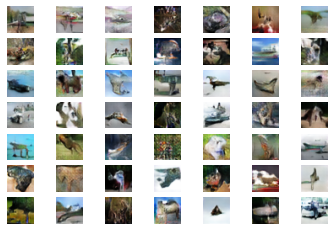

> Epoch 71, batch 1/390: d_loss1=0.603, d_loss2=0.575, g_loss=0.881
> Epoch 71, batch 195/390: d_loss1=0.668, d_loss2=0.612, g_loss=0.908
> Epoch 71, batch 390/390: d_loss1=0.629, d_loss2=0.620, g_loss=0.876
> Epoch 72, batch 1/390: d_loss1=0.663, d_loss2=0.619, g_loss=0.942
> Epoch 72, batch 195/390: d_loss1=0.655, d_loss2=0.656, g_loss=0.789
> Epoch 72, batch 390/390: d_loss1=0.639, d_loss2=0.595, g_loss=0.849
> Epoch 73, batch 1/390: d_loss1=0.682, d_loss2=0.679, g_loss=0.862
> Epoch 73, batch 195/390: d_loss1=0.637, d_loss2=0.669, g_loss=0.913
> Epoch 73, batch 390/390: d_loss1=0.679, d_loss2=0.636, g_loss=0.877
> Epoch 74, batch 1/390: d_loss1=0.668, d_loss2=0.678, g_loss=0.871
> Epoch 74, batch 195/390: d_loss1=0.679, d_loss2=0.639, g_loss=0.891
> Epoch 74, batch 390/390: d_loss1=0.678, d_loss2=0.618, g_loss=0.909
> Epoch 75, batch 1/390: d_loss1=0.678, d_loss2=0.639, g_loss=0.860
> Epoch 75, batch 195/390: d_loss1=0.676, d_loss2=0.591, g_loss=0.930
> Epoch 75, batch 390/390: d_l

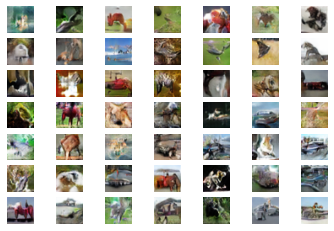

> Epoch 81, batch 1/390: d_loss1=0.673, d_loss2=0.672, g_loss=0.979
> Epoch 81, batch 195/390: d_loss1=0.629, d_loss2=0.673, g_loss=0.981
> Epoch 81, batch 390/390: d_loss1=0.633, d_loss2=0.694, g_loss=0.912
> Epoch 82, batch 1/390: d_loss1=0.649, d_loss2=0.603, g_loss=0.899
> Epoch 82, batch 195/390: d_loss1=0.611, d_loss2=0.625, g_loss=0.849
> Epoch 82, batch 390/390: d_loss1=0.725, d_loss2=0.626, g_loss=0.930
> Epoch 83, batch 1/390: d_loss1=0.628, d_loss2=0.628, g_loss=0.881
> Epoch 83, batch 195/390: d_loss1=0.524, d_loss2=0.586, g_loss=0.915
> Epoch 83, batch 390/390: d_loss1=0.662, d_loss2=0.673, g_loss=0.925
> Epoch 84, batch 1/390: d_loss1=0.642, d_loss2=0.669, g_loss=0.905
> Epoch 84, batch 195/390: d_loss1=0.698, d_loss2=0.684, g_loss=0.927
> Epoch 84, batch 390/390: d_loss1=0.620, d_loss2=0.564, g_loss=0.961
> Epoch 85, batch 1/390: d_loss1=0.572, d_loss2=0.671, g_loss=0.907
> Epoch 85, batch 195/390: d_loss1=0.643, d_loss2=0.634, g_loss=0.905
> Epoch 85, batch 390/390: d_l

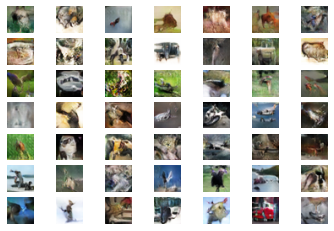

> Epoch 91, batch 1/390: d_loss1=0.672, d_loss2=0.641, g_loss=0.884
> Epoch 91, batch 195/390: d_loss1=0.693, d_loss2=0.554, g_loss=0.934
> Epoch 91, batch 390/390: d_loss1=0.630, d_loss2=0.598, g_loss=0.953
> Epoch 92, batch 1/390: d_loss1=0.645, d_loss2=0.588, g_loss=0.935
> Epoch 92, batch 195/390: d_loss1=0.600, d_loss2=0.628, g_loss=0.962
> Epoch 92, batch 390/390: d_loss1=0.580, d_loss2=0.599, g_loss=0.889
> Epoch 93, batch 1/390: d_loss1=0.669, d_loss2=0.667, g_loss=0.930
> Epoch 93, batch 195/390: d_loss1=0.613, d_loss2=0.648, g_loss=0.955
> Epoch 93, batch 390/390: d_loss1=0.639, d_loss2=0.594, g_loss=0.913
> Epoch 94, batch 1/390: d_loss1=0.663, d_loss2=0.647, g_loss=0.939
> Epoch 94, batch 195/390: d_loss1=0.549, d_loss2=0.570, g_loss=0.891
> Epoch 94, batch 390/390: d_loss1=0.613, d_loss2=0.556, g_loss=0.880
> Epoch 95, batch 1/390: d_loss1=0.581, d_loss2=0.790, g_loss=0.911
> Epoch 95, batch 195/390: d_loss1=0.651, d_loss2=0.629, g_loss=1.022
> Epoch 95, batch 390/390: d_l

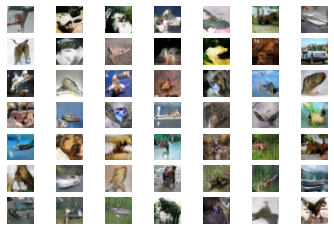

> Epoch 101, batch 1/390: d_loss1=0.552, d_loss2=0.667, g_loss=0.983
> Epoch 101, batch 195/390: d_loss1=0.616, d_loss2=0.595, g_loss=0.953
> Epoch 101, batch 390/390: d_loss1=0.636, d_loss2=0.585, g_loss=0.941
> Epoch 102, batch 1/390: d_loss1=0.591, d_loss2=0.609, g_loss=0.956
> Epoch 102, batch 195/390: d_loss1=0.621, d_loss2=0.601, g_loss=1.025
> Epoch 102, batch 390/390: d_loss1=0.618, d_loss2=0.624, g_loss=0.892
> Epoch 103, batch 1/390: d_loss1=0.612, d_loss2=0.643, g_loss=0.922
> Epoch 103, batch 195/390: d_loss1=0.664, d_loss2=0.691, g_loss=0.989
> Epoch 103, batch 390/390: d_loss1=0.634, d_loss2=0.640, g_loss=0.962
> Epoch 104, batch 1/390: d_loss1=0.675, d_loss2=0.591, g_loss=0.951
> Epoch 104, batch 195/390: d_loss1=0.605, d_loss2=0.570, g_loss=0.964
> Epoch 104, batch 390/390: d_loss1=0.606, d_loss2=0.580, g_loss=0.954
> Epoch 105, batch 1/390: d_loss1=0.688, d_loss2=0.639, g_loss=0.959
> Epoch 105, batch 195/390: d_loss1=0.594, d_loss2=0.542, g_loss=0.962
> Epoch 105, bat

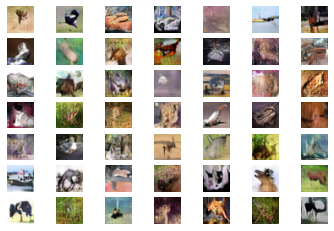

> Epoch 111, batch 1/390: d_loss1=0.611, d_loss2=0.623, g_loss=0.967
> Epoch 111, batch 195/390: d_loss1=0.610, d_loss2=0.619, g_loss=1.016
> Epoch 111, batch 390/390: d_loss1=0.598, d_loss2=0.637, g_loss=0.979
> Epoch 112, batch 1/390: d_loss1=0.651, d_loss2=0.559, g_loss=0.989
> Epoch 112, batch 195/390: d_loss1=0.510, d_loss2=0.591, g_loss=1.078
> Epoch 112, batch 390/390: d_loss1=0.598, d_loss2=0.616, g_loss=0.962
> Epoch 113, batch 1/390: d_loss1=0.619, d_loss2=0.540, g_loss=0.943
> Epoch 113, batch 195/390: d_loss1=0.705, d_loss2=0.596, g_loss=1.004
> Epoch 113, batch 390/390: d_loss1=0.581, d_loss2=0.584, g_loss=0.965
> Epoch 114, batch 1/390: d_loss1=0.652, d_loss2=0.640, g_loss=1.006
> Epoch 114, batch 195/390: d_loss1=0.604, d_loss2=0.584, g_loss=0.978
> Epoch 114, batch 390/390: d_loss1=0.565, d_loss2=0.563, g_loss=0.995
> Epoch 115, batch 1/390: d_loss1=0.733, d_loss2=0.582, g_loss=1.012
> Epoch 115, batch 195/390: d_loss1=0.619, d_loss2=0.570, g_loss=1.016
> Epoch 115, bat

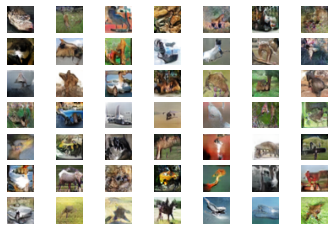

> Epoch 121, batch 1/390: d_loss1=0.558, d_loss2=0.573, g_loss=0.983
> Epoch 121, batch 195/390: d_loss1=0.610, d_loss2=0.660, g_loss=1.027
> Epoch 121, batch 390/390: d_loss1=0.664, d_loss2=0.531, g_loss=1.111
> Epoch 122, batch 1/390: d_loss1=0.653, d_loss2=0.620, g_loss=1.099
> Epoch 122, batch 195/390: d_loss1=0.520, d_loss2=0.591, g_loss=1.084
> Epoch 122, batch 390/390: d_loss1=0.579, d_loss2=0.636, g_loss=1.036
> Epoch 123, batch 1/390: d_loss1=0.564, d_loss2=0.576, g_loss=1.018
> Epoch 123, batch 195/390: d_loss1=0.638, d_loss2=0.575, g_loss=0.964
> Epoch 123, batch 390/390: d_loss1=0.606, d_loss2=0.570, g_loss=1.060
> Epoch 124, batch 1/390: d_loss1=0.683, d_loss2=0.553, g_loss=1.049
> Epoch 124, batch 195/390: d_loss1=0.572, d_loss2=0.584, g_loss=1.119
> Epoch 124, batch 390/390: d_loss1=0.598, d_loss2=0.565, g_loss=0.968
> Epoch 125, batch 1/390: d_loss1=0.562, d_loss2=0.594, g_loss=1.046
> Epoch 125, batch 195/390: d_loss1=0.552, d_loss2=0.591, g_loss=1.030
> Epoch 125, bat

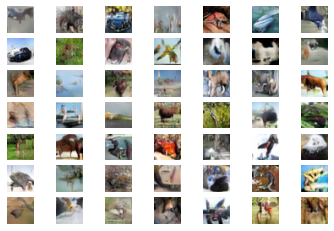

> Epoch 131, batch 1/390: d_loss1=0.703, d_loss2=0.549, g_loss=1.018
> Epoch 131, batch 195/390: d_loss1=0.539, d_loss2=0.502, g_loss=1.063
> Epoch 131, batch 390/390: d_loss1=0.568, d_loss2=0.544, g_loss=1.049
> Epoch 132, batch 1/390: d_loss1=0.567, d_loss2=0.595, g_loss=1.073
> Epoch 132, batch 195/390: d_loss1=0.616, d_loss2=0.577, g_loss=0.959
> Epoch 132, batch 390/390: d_loss1=0.608, d_loss2=0.512, g_loss=1.136
> Epoch 133, batch 1/390: d_loss1=0.491, d_loss2=0.500, g_loss=1.122
> Epoch 133, batch 195/390: d_loss1=0.590, d_loss2=0.629, g_loss=1.109
> Epoch 133, batch 390/390: d_loss1=0.566, d_loss2=0.584, g_loss=1.146
> Epoch 134, batch 1/390: d_loss1=0.589, d_loss2=0.639, g_loss=1.136
> Epoch 134, batch 195/390: d_loss1=0.719, d_loss2=0.603, g_loss=1.078
> Epoch 134, batch 390/390: d_loss1=0.571, d_loss2=0.630, g_loss=1.080
> Epoch 135, batch 1/390: d_loss1=0.650, d_loss2=0.563, g_loss=1.030
> Epoch 135, batch 195/390: d_loss1=0.639, d_loss2=0.514, g_loss=1.054
> Epoch 135, bat

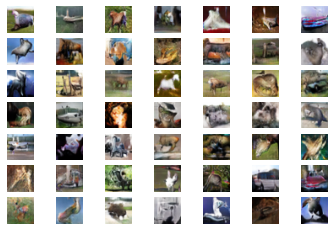

> Epoch 141, batch 1/390: d_loss1=0.550, d_loss2=0.614, g_loss=1.095
> Epoch 141, batch 195/390: d_loss1=0.640, d_loss2=0.656, g_loss=1.021
> Epoch 141, batch 390/390: d_loss1=0.560, d_loss2=0.563, g_loss=1.080
> Epoch 142, batch 1/390: d_loss1=0.654, d_loss2=0.568, g_loss=1.054
> Epoch 142, batch 195/390: d_loss1=0.586, d_loss2=0.560, g_loss=1.172
> Epoch 142, batch 390/390: d_loss1=0.641, d_loss2=0.681, g_loss=1.058
> Epoch 143, batch 1/390: d_loss1=0.630, d_loss2=0.506, g_loss=1.125
> Epoch 143, batch 195/390: d_loss1=0.498, d_loss2=0.552, g_loss=1.105
> Epoch 143, batch 390/390: d_loss1=0.531, d_loss2=0.678, g_loss=1.216
> Epoch 144, batch 1/390: d_loss1=0.601, d_loss2=0.458, g_loss=1.056
> Epoch 144, batch 195/390: d_loss1=0.704, d_loss2=0.586, g_loss=1.084
> Epoch 144, batch 390/390: d_loss1=0.619, d_loss2=0.691, g_loss=1.072
> Epoch 145, batch 1/390: d_loss1=0.612, d_loss2=0.532, g_loss=1.110
> Epoch 145, batch 195/390: d_loss1=0.592, d_loss2=0.572, g_loss=1.127
> Epoch 145, bat

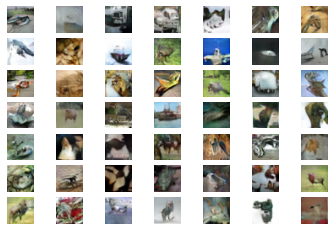

> Epoch 151, batch 1/390: d_loss1=0.621, d_loss2=0.579, g_loss=1.152
> Epoch 151, batch 195/390: d_loss1=0.552, d_loss2=0.698, g_loss=1.136
> Epoch 151, batch 390/390: d_loss1=0.526, d_loss2=0.607, g_loss=1.127
> Epoch 152, batch 1/390: d_loss1=0.564, d_loss2=0.532, g_loss=1.131
> Epoch 152, batch 195/390: d_loss1=0.662, d_loss2=0.530, g_loss=1.225
> Epoch 152, batch 390/390: d_loss1=0.601, d_loss2=0.553, g_loss=1.147
> Epoch 153, batch 1/390: d_loss1=0.590, d_loss2=0.627, g_loss=1.085
> Epoch 153, batch 195/390: d_loss1=0.813, d_loss2=0.625, g_loss=1.100
> Epoch 153, batch 390/390: d_loss1=0.526, d_loss2=0.583, g_loss=1.098
> Epoch 154, batch 1/390: d_loss1=0.567, d_loss2=0.609, g_loss=1.159
> Epoch 154, batch 195/390: d_loss1=0.598, d_loss2=0.603, g_loss=1.109
> Epoch 154, batch 390/390: d_loss1=0.487, d_loss2=0.526, g_loss=1.175
> Epoch 155, batch 1/390: d_loss1=0.617, d_loss2=0.491, g_loss=1.103
> Epoch 155, batch 195/390: d_loss1=0.532, d_loss2=0.544, g_loss=1.108
> Epoch 155, bat

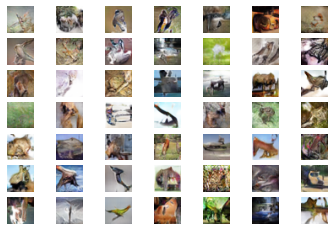

> Epoch 161, batch 1/390: d_loss1=0.567, d_loss2=0.492, g_loss=1.085
> Epoch 161, batch 195/390: d_loss1=0.570, d_loss2=0.565, g_loss=1.054
> Epoch 161, batch 390/390: d_loss1=0.580, d_loss2=0.437, g_loss=1.172
> Epoch 162, batch 1/390: d_loss1=0.605, d_loss2=0.481, g_loss=1.195
> Epoch 162, batch 195/390: d_loss1=0.555, d_loss2=0.495, g_loss=1.128
> Epoch 162, batch 390/390: d_loss1=0.547, d_loss2=0.477, g_loss=1.168
> Epoch 163, batch 1/390: d_loss1=0.557, d_loss2=0.567, g_loss=1.121
> Epoch 163, batch 195/390: d_loss1=0.421, d_loss2=0.555, g_loss=1.161
> Epoch 163, batch 390/390: d_loss1=0.560, d_loss2=0.589, g_loss=1.287
> Epoch 164, batch 1/390: d_loss1=0.625, d_loss2=0.445, g_loss=1.291
> Epoch 164, batch 195/390: d_loss1=0.632, d_loss2=0.492, g_loss=1.223
> Epoch 164, batch 390/390: d_loss1=0.502, d_loss2=0.500, g_loss=1.367
> Epoch 165, batch 1/390: d_loss1=0.631, d_loss2=0.548, g_loss=1.359
> Epoch 165, batch 195/390: d_loss1=0.542, d_loss2=0.540, g_loss=1.300
> Epoch 165, bat

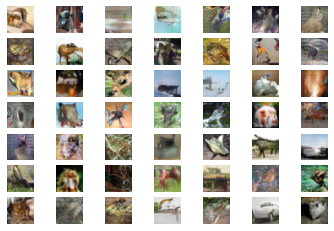

> Epoch 171, batch 1/390: d_loss1=0.554, d_loss2=0.559, g_loss=1.188
> Epoch 171, batch 195/390: d_loss1=0.602, d_loss2=0.548, g_loss=1.221
> Epoch 171, batch 390/390: d_loss1=0.482, d_loss2=0.479, g_loss=1.148
> Epoch 172, batch 1/390: d_loss1=0.492, d_loss2=0.490, g_loss=1.274
> Epoch 172, batch 195/390: d_loss1=0.615, d_loss2=0.547, g_loss=1.243
> Epoch 172, batch 390/390: d_loss1=0.553, d_loss2=0.592, g_loss=1.271
> Epoch 173, batch 1/390: d_loss1=0.558, d_loss2=0.610, g_loss=1.337
> Epoch 173, batch 195/390: d_loss1=0.573, d_loss2=0.546, g_loss=1.272
> Epoch 173, batch 390/390: d_loss1=0.665, d_loss2=0.515, g_loss=1.190
> Epoch 174, batch 1/390: d_loss1=0.513, d_loss2=0.572, g_loss=1.174
> Epoch 174, batch 195/390: d_loss1=0.565, d_loss2=0.517, g_loss=1.252
> Epoch 174, batch 390/390: d_loss1=0.496, d_loss2=0.582, g_loss=1.166
> Epoch 175, batch 1/390: d_loss1=0.613, d_loss2=0.555, g_loss=1.249
> Epoch 175, batch 195/390: d_loss1=0.555, d_loss2=0.508, g_loss=1.244
> Epoch 175, bat

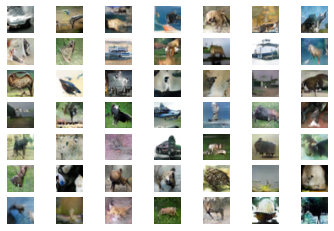

> Epoch 181, batch 1/390: d_loss1=0.584, d_loss2=0.548, g_loss=1.230
> Epoch 181, batch 195/390: d_loss1=0.576, d_loss2=0.580, g_loss=1.264
> Epoch 181, batch 390/390: d_loss1=0.539, d_loss2=0.464, g_loss=1.211
> Epoch 182, batch 1/390: d_loss1=0.504, d_loss2=0.463, g_loss=1.230
> Epoch 182, batch 195/390: d_loss1=0.688, d_loss2=0.560, g_loss=1.215
> Epoch 182, batch 390/390: d_loss1=0.564, d_loss2=0.536, g_loss=1.348
> Epoch 183, batch 1/390: d_loss1=0.585, d_loss2=0.588, g_loss=1.276
> Epoch 183, batch 195/390: d_loss1=0.540, d_loss2=0.574, g_loss=1.193
> Epoch 183, batch 390/390: d_loss1=0.497, d_loss2=0.560, g_loss=1.161
> Epoch 184, batch 1/390: d_loss1=0.583, d_loss2=0.474, g_loss=1.308
> Epoch 184, batch 195/390: d_loss1=0.508, d_loss2=0.505, g_loss=1.379
> Epoch 184, batch 390/390: d_loss1=0.499, d_loss2=0.588, g_loss=1.254
> Epoch 185, batch 1/390: d_loss1=0.598, d_loss2=0.477, g_loss=1.103
> Epoch 185, batch 195/390: d_loss1=0.648, d_loss2=0.496, g_loss=1.230
> Epoch 185, bat

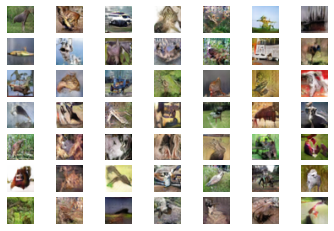

> Epoch 191, batch 1/390: d_loss1=0.512, d_loss2=0.574, g_loss=1.393
> Epoch 191, batch 195/390: d_loss1=0.494, d_loss2=0.439, g_loss=1.257
> Epoch 191, batch 390/390: d_loss1=0.649, d_loss2=0.502, g_loss=1.290
> Epoch 192, batch 1/390: d_loss1=0.573, d_loss2=0.433, g_loss=1.356
> Epoch 192, batch 195/390: d_loss1=0.559, d_loss2=0.491, g_loss=1.365
> Epoch 192, batch 390/390: d_loss1=0.563, d_loss2=0.498, g_loss=1.316
> Epoch 193, batch 1/390: d_loss1=0.601, d_loss2=0.596, g_loss=1.281
> Epoch 193, batch 195/390: d_loss1=0.563, d_loss2=0.545, g_loss=1.236
> Epoch 193, batch 390/390: d_loss1=0.560, d_loss2=0.484, g_loss=1.242
> Epoch 194, batch 1/390: d_loss1=0.492, d_loss2=0.564, g_loss=1.237
> Epoch 194, batch 195/390: d_loss1=0.569, d_loss2=0.493, g_loss=1.238
> Epoch 194, batch 390/390: d_loss1=0.466, d_loss2=0.533, g_loss=1.330
> Epoch 195, batch 1/390: d_loss1=0.616, d_loss2=0.477, g_loss=1.295
> Epoch 195, batch 195/390: d_loss1=0.711, d_loss2=0.509, g_loss=1.376
> Epoch 195, bat

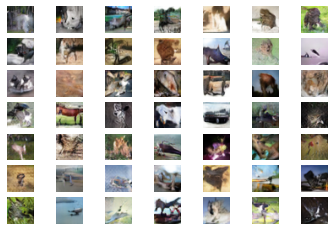

In [17]:
train_gan(generator, discriminator, gan_model, dataset, latent_dim)